Today we'll be working on creating a cat breed identification model using FastAI and build upon this to make a recommender model to recommend cats based on the similarity.  
Lets start off with getting all our imports!

In [1]:
import os
import torch
from fastai import *
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision import *
from fastai.vision.all import *
from fastai.metrics import error_rate, accuracy
import numpy as np
import pandas as pd
import matplotlib as plt
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Gathering our Data  


In [2]:
path = Path("/kaggle/input/cat-breed/cat-breed")
path.ls()

(#2) [Path('/kaggle/input/cat-breed/cat-breed/TEST'),Path('/kaggle/input/cat-breed/cat-breed/TRAIN')]

The ImageDataLoaders() function from FastAI allows us to create a DataLoaders for our train, test and validation split directly from our folders structure.

In [3]:
bs = 60

dls = ImageDataLoaders.from_folder(path, valid_pct=0.2, item_tfms=Resize(225), bs=bs)

Lets have a look at a few of the images and the assigned breed for them...

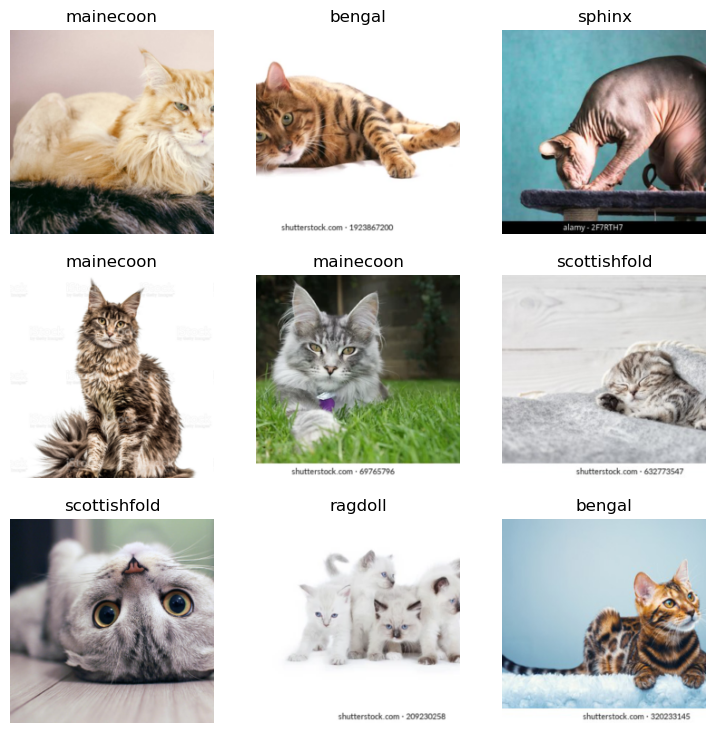

In [4]:
dls.show_batch()

# Creating our Model  
The next step is making our Neural network. In order to speed up the training process as well as get accurate predictions, we'll use a pre-existing model (ResNet) and input our dataloader onto that so we can define our model


In [5]:
learn = vision_learner(dls, resnet50, metrics=[accuracy, error_rate])

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

We'll now fine tune the model to make it more accurate to predict the breeds of the cats. ResNet is a general pre-trained base which can identify features since it is trained on millions of images. However, to more accurately define the features of our cat breeds, we'll have to let it train and learn the different characteristics of those...  
We'll set base_lr (base learning rate) low so that the weights of the final layers isnt too high.

In [6]:
learn.fine_tune(5,base_lr=0.001)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.330617,0.311942,0.916388,0.083612,00:23


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.295004,0.239097,0.933110,0.066890,00:19
1,0.193865,0.245982,0.936455,0.063545,00:19
2,0.134723,0.230963,0.936455,0.063545,00:19
3,0.095236,0.217765,0.943144,0.056856,00:20
4,0.071158,0.214920,0.943144,0.056856,00:19


An accuracy of roughly 93% which is fairly good! Despite how little number of training images we had, the model was able to pick up features and identify them accurately.

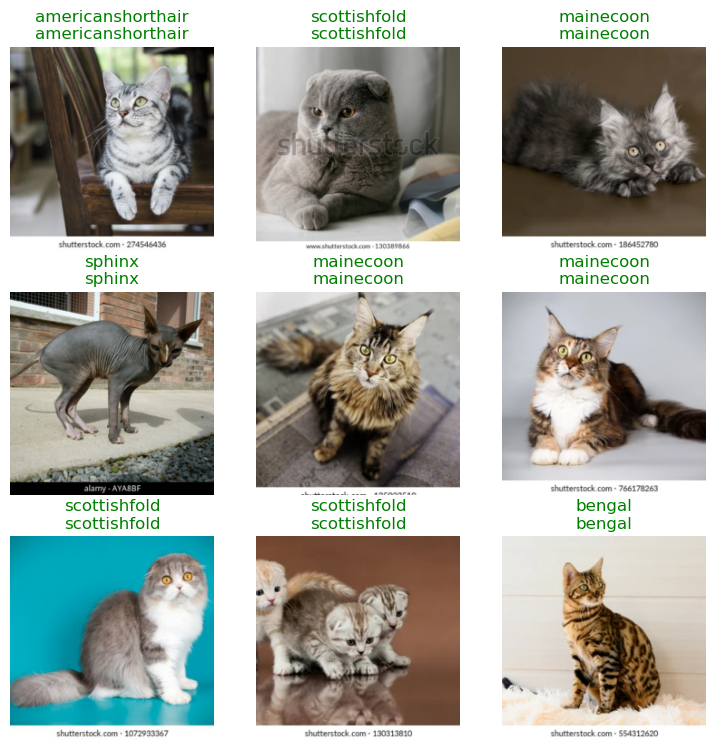

In [7]:
learn.show_results()

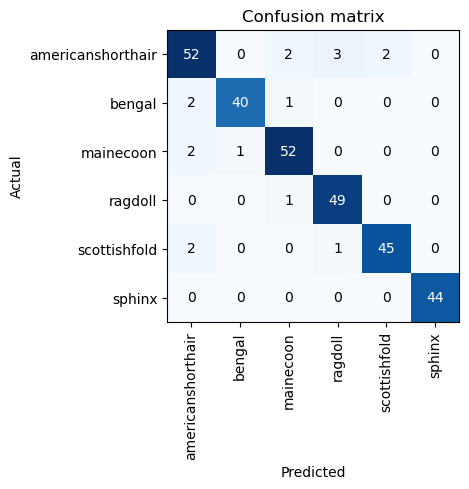

In [8]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# Creating Our Recommendation System  
In order to create our recommendation system, we will be required to get the location of all the images in the validation folder and run them through our model which can identify the features and predictions, which we will later use to calculate the cosine similaritiy in order to get similair recommendations.

In [9]:
folder_list=[]
for folder in os.listdir("/kaggle/input/cat-breed/cat-breed/TRAIN"):
    folder_list.append(folder)
folder_list

['ragdoll',
 'sphinx',
 'bengal',
 'americanshorthair',
 'scottishfold',
 'mainecoon']

In [10]:
image_list = []

for breed in folder_list:
    image_list.append(os.listdir(f'/kaggle/input/cat-breed/cat-breed/TRAIN/{breed}'))


In [11]:
final_image_list = []
for i in image_list:
    for j in i:
        final_image_list.append(j)

We have a total of 1200 images all in a single location that we can pull out now!

In [12]:
len(final_image_list)

1200

The following lines get each image from their respective location, have the model predict them and store the tensorbase output values in a prediction list which we can easily access.

In [13]:
counter=0
prediction_list = []
location_list=[]
for breed in folder_list:
    for imageid in range(0,200):  #Since there are 200 images for each folder
        location=f'/kaggle/input/cat-breed/cat-breed/TRAIN/{breed}/{final_image_list[counter]}'
        location_list.append(location)
        with learn.no_bar(), learn.no_logging():
            prediction_list.append(learn.predict(location)[2].tolist())
        counter+=1

# Creating Cosine Similarity Matrix  
The following lines use scikits cosine similarity functions to get the similairty vectors of each and every image

In [14]:
# compute cosine similarities between images
cosSimilarities = cosine_similarity(prediction_list)

# store the results into a pandas dataframe
cos_similarities_df = pd.DataFrame(cosSimilarities)
cos_similarities_df.shape

(1200, 1200)

Now lets define the main function for getting the similair products based on their id. We sort our dataframe based on the given id with the highest values and take out the top 5 which we will recommend to the user.  

In [15]:
import matplotlib.pyplot as plt

def retrieve_most_similar_products(id):

    print("original cat picture:")
    im = Image.open(location_list[id]) 
    plt.imshow(im)
    plt.show()
    print("most similar cat pictures to recommend:")

    closest_imgs = cos_similarities_df[id].sort_values(ascending=False)[1:6].index
    closest_imgs_scores = cos_similarities_df[id].sort_values(ascending=False)[1:6]
    
    
    for i in closest_imgs:
        im = Image.open(location_list[i]) 
        plt.imshow(im)
        plt.show()

# Testing our Recommender Out

original cat picture:


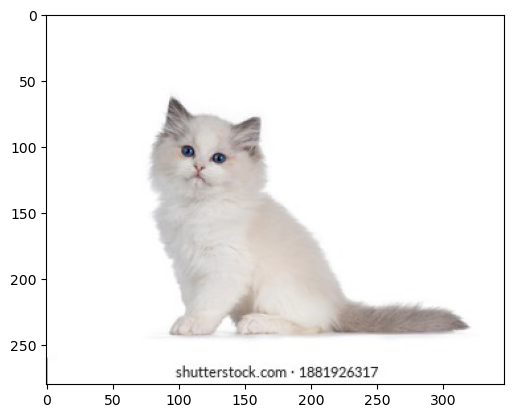

most similar cat pictures to recommend:


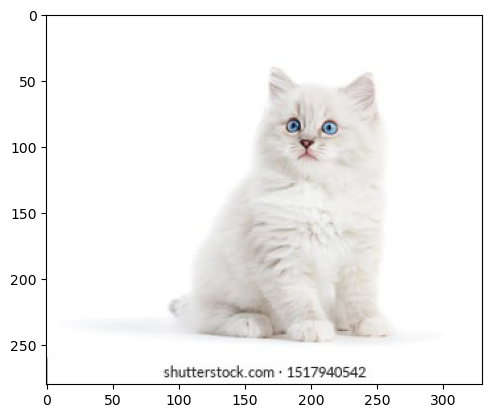

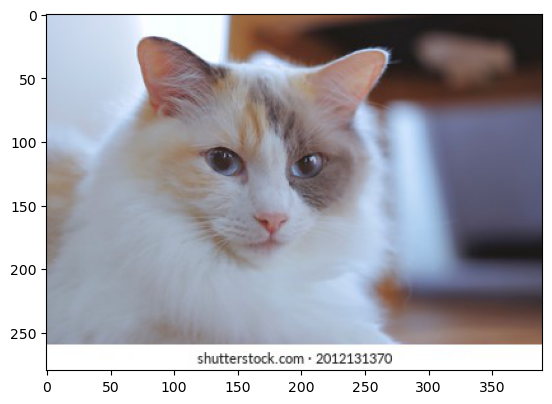

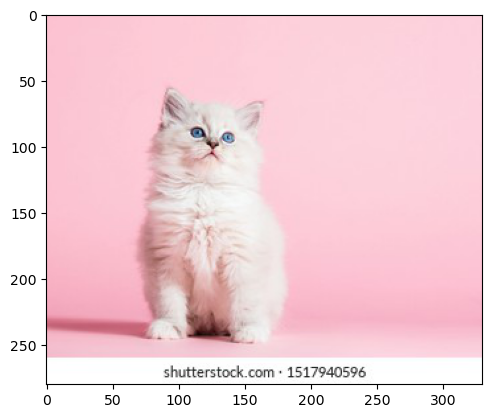

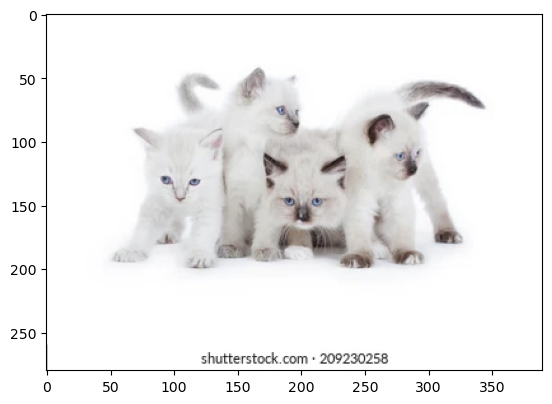

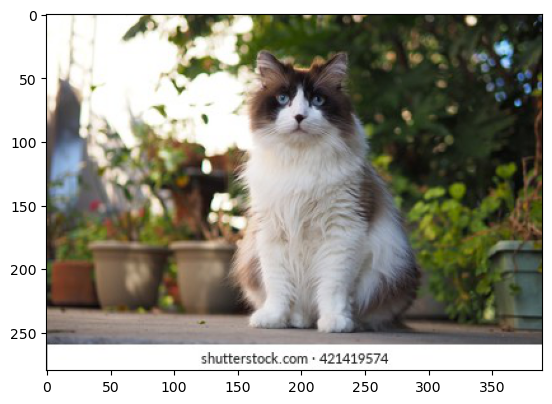

In [16]:
retrieve_most_similar_products(3)

original cat picture:


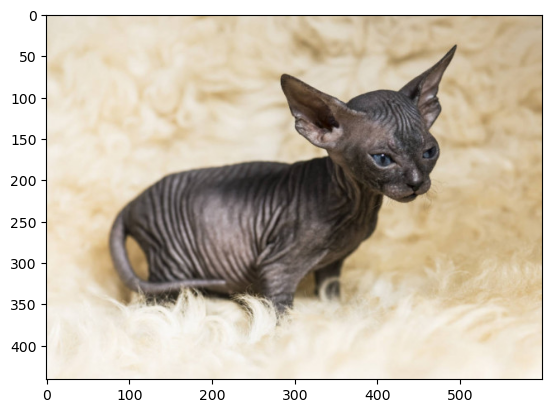

most similar cat pictures to recommend:


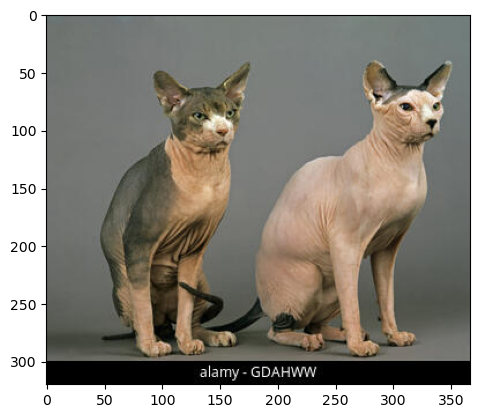

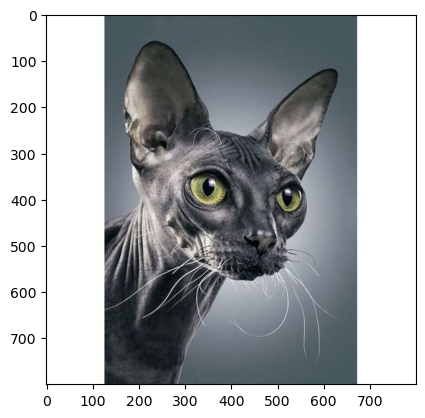

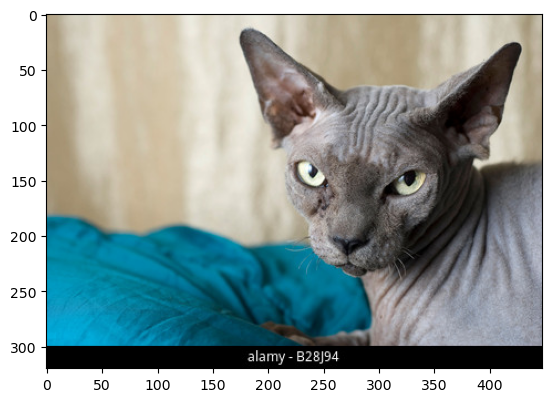

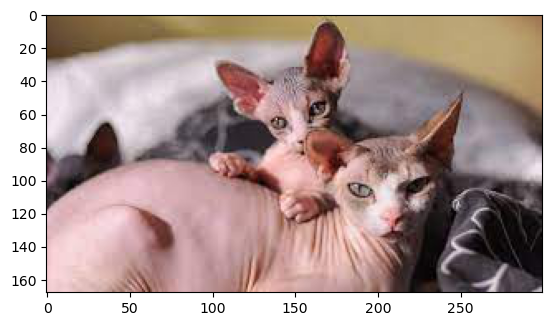

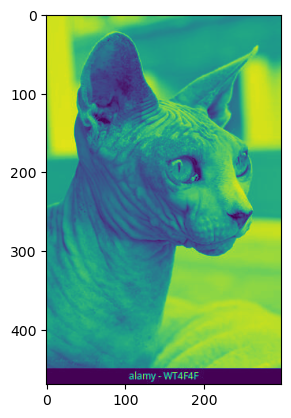

In [17]:
retrieve_most_similar_products(242)

Sure enough, the system seems to be working extremely well by identifying the most similair images and displaying them.  
Thats all for today!